# Inventory Control and the stochastic dynamic programming algorithm
Inventory control problems are nice examples of the use the dynamic programming 
algorithm in the context of stage decision problems. Typically the demand is 
stochastic, and therefore one needs to resort to the stochastic dynamic programming 
algorithm.

Suppose that we wish to control the inventory (number of items) of a given 
product along $h \in \mathbb{N}$ stages. The number of items is described 
by

$$ x_{k+1} = \max\{x_k+u_k-d_k,0\}, \ \ \ k \in \{0,\dots,h-1\},$$

where $x_k \in \{0,\dots, N\}$, $u_k \in \{0,\dots,N-x_k\}$, $d_k \in 
\mathbb{N} \cup \{0\}$denote the number of items, the supply and the demand 
at time $k$, respectively, and $N$ is the capacity. The demand is unknown 
and follows a given distribution.



The objective is to find supplies that minimize the expected cost

$$\mathbb{E}[ \sum_{k=0}^{h-1}  \big(c_1(x_k)+c_2(u_k) -p\min\{x_k+u_k,d_k\}\big)+ 
g_h(x_h)],$$

where $c_1(i) = c_{\text{stor}}i$, $ i\in \{0,\dots,N\}$, is the storage 
cost, 

$$c_2(j) =  c_{\text{item}}j+c_{\text{trans}} \text{ if }j>0 $$

and

$$ c_2(j) =  0\text{ if }j=0$$

is the cost of ordering $j$ items, $c_{\text{item}}$ is the cost per item 
and $c_{\text{trans}}$ is the transportation cost.  Moreover, $p$ is the 
selling price per item, and $g_h(i)$, $ i\in \{0,\dots,N\}$, is the terminal 
cost.

This live script uses the function stochdp.m to find the optimal policy for 
such a problem. The parameters that fully characterize such an inventory control 
problem are $p$, $c_{\text{stor}}$, $c_{\text{item}}$, $c_{\text{trans}}$, 
the  probability distribution of demands, and the terminal cost, which we represent 
in a vector $g_h = [g_h(0) \dots g_h(N)]$. An example is given next, where 
one value of the demand is stochastic.

In [ ]:
import numpy as np

In [ ]:
def stochdp(M, C, P, Jh, h):
    n = int(len(M[0])) # statedimension
    J = Jh
    J_ = np.zeros([n, h])
    u_ = np.zeros([n, h])

    for k in range(h-1, -1, -1):
        for i in range(0, n):
            nj = len(M[k][i])
            caux = np.zeros(nj)
            for j in range(0, nj):
                caux[j] = 0
                for l in range(0, len(M[k][i][j])):
                    caux[j] = caux[j] + P[k][i][j][l] * (C[k][i][j][l] + J[int(M[k][i][j][l]-1)])
            J_[i, k] = np.min(caux)
            u_[i, k] = np.argmin(caux)
        J = J_[:, k]

    return J_, u_

In [ ]:
p = 10
citem = 5
ctr = 0.5
c1_ = 0.2
d = np.array([2, 2, 1, 1]) # nominal values, d3 is however stochastic
h = 4
N = 4


# Preallocate for k and i
DM = [[[] for _ in range(5)] for _ in range(h)]
CM = [[[] for _ in range(5)] for _ in range(h)]
PM = [[[] for _ in range(5)] for _ in range(h)]

for k in range(0, h):
    if k != 2:
        for i in range(0, 5):
            for j in range(-1, N + d[k] - i ):

                if len(DM[k][i]) == 0 or len(DM[k][i]) == j+1:
                    DM[k][i].append([])
                    PM[k][i].append([])
                    CM[k][i].append([])

                i_1 = np.max(np.array([i + j + 1 - d[k], 0])) + 1
                DM[k][i][j+1] = np.append(DM[k][i][j+1], [i_1])
                PM[k][i][j+1] = np.append(PM[k][i][j+1], 1)
                c2 = citem * (j+1)

                if j > -1:
                    c2 = c2 + ctr
                c1 = i * c1_
                CM[k][i][j+1] = np.append(CM[k][i][j+1], -1 * (np.min([d[k], j + 1 + i]) * p - (c1 + c2)))

    else:
        d_3 = 0

        for i in range(0, 5):
            for j in range(-1, N + d[k] - i):
                i_1 = np.max([i + j + 1 - d[k], 0]) + 1

                if len(DM[k][i]) == 0 or len(DM[k][i]) == j+1:
                    DM[k][i].append([])
                    PM[k][i].append([])
                    CM[k][i].append([])

                DM[k][i][j+1] = np.append(DM[k][i][j+1], i_1)
                PM[k][i][j+1] = np.append(PM[k][i][j+1], 0.5)
                c2 = citem * (j + 1)
                if j > -1:
                    c2 = c2 + ctr
                c1 = i * c1_
                CM[k][i][j+1] = np.append(CM[k][i][j+1], -1 * (np.min([d[k], j + 1 + i]) * p - (c1 + c2)))

            for j in range(-1, N + d_3 - i):
                i_1 = np.max([i + j + 1 - d_3 , 0])+1

                if len(DM[k][i]) == 0 or len(DM[k][i]) == j+1:
                    DM[k][i].append([])
                    PM[k][i].append([])
                    CM[k][i].append([])

                DM[k][i][j+1] = np.append(DM[k][i][j+1], i_1)
                PM[k][i][j+1] = np.append(PM[k][i][j+1], 0.5)
                c2 = citem * (j + 1)

                if j > -1:
                    c2 = c2 + ctr

                c1 = i * c1_
                CM[k][i][j+1] = np.append(CM[k][i][j+1], -1 * (np.min([d_3, j + 1 + i]) * p - (c1 + c2)))
    
    # 3 determine final cost
    Jh = -np.array([0, citem - c1_, 2 * (citem - c1_), 3 * (citem - c1_), 4 * (citem - c1_)])


In [ ]:
# 4 apply dynamic programming
[J, u] = stochdp(DM, CM, PM, Jh, h)

In [ ]:
u

In [ ]:
J

The result, i.e., the optimal policy and the expected costs-to-go are depicted 
in Figure 2 (costs-to-go on top, and optimal policy specified by the arrows).


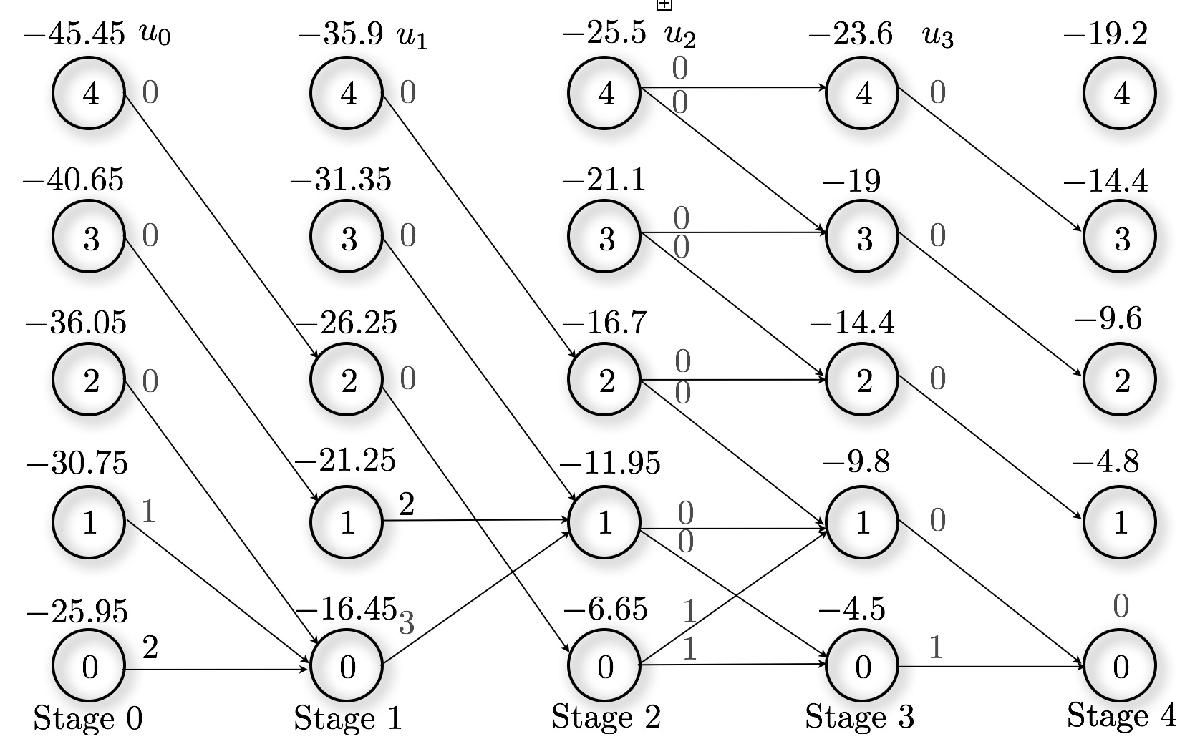
<center>Figure 2: Optimal policy and costs-to-go</center>



A crucial function to solve this problem is the function given below implementing 
the stochastic dynamic programming algorithm. It is a general function to solve 
a general Markov decision problem, and it deserves some further explanation.

Let us start by recalling the formulation of a Markov decision problem

$$ \min  \mathbb{E}[\sum_{k=0}^{h-1} g_k( x_k, u_k,w_k ) + g_h( x_h )] 
$$

subject to

$$ x_{k+1} = f_k( x_k, u_k,w_k),$$

where $k\in K:=\{0,1,2,\dots,h-1\}$, $x_k\in X_k:=\{1,2,\dots,n_k\}$, 
for $k\in K \cup \{h\}$ and $u_k \in U_k(x_k):=\{1,2,\dots,m_k(x_k)\}$ for 
$k\in K$ and $x_k \in X_k$. Moreover, $w_k \in W_k(x_k,u_k):=\{1,2,\dots,p_k(x_k,u_k)\}$ 
with $\text{Prob}[w_k=\ell|x_k,u_k]:=p_\ell^{k,x_k,u_k})\}$  $j\in W_K(x_k,u_k)$ 
for$j \in W_K(x_k,u_k)$.

We need to find a good representation for this problem in terms of Matlab 
data structures. To this effect consider the following data structures, which 
fully characterize the optimal control problem:

* M - cell object such that M{k+1}{i}{j}{$\ell$} = $f_k(i,j,\ell)$;
* C- cell object such that C{k+1}{i}{j}{$\ell$} = $g_k(i,j,\ell)$;
* P- cell object such that P{k+1}{i}{j}{$\ell$} = $p_\ell^{k,i,j}$;
* T- vector such that T(i)=$g_h(i), \ \ i\in X_h$;

The dynamic programming algorithm will result in an optimal policy and in costs-to-go. These can be specified by the following data structures:

* $J$ - cell object such that $J\{k+1\}\{i\}$ is the (expected) costs-to-go 
at stage $k$, $k\in K $, and state $i$; Note that the terminal cost is 
not included.
* $u$ - cell object such that $u\{k+1\}\{i\}$ is a vector of indices $j$  
corresponding to the optimal actions (possibly more than one) for each stage 
$k$, $k\in K $,  and state ${i}$.